### Amazon Fine Food Reviews

#### Project By:
Girija Suresh Dhawale | Yash Kumar Abinash | Zhenghui Li

### Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews
This dataset consists of reviews of fine foods from Amazon. Reviews include product and user information, ratings, and a plain text review.

This dataset has a Reviews.csv file and a database.sqlite file which can used to implement sql commands. We have used the sql file in our project by importing the library sqlite3.

##### Data includes:

Timespan: Reviews from Oct 1999 - Oct 2012 

Number of reviews: 568,454 reviews 

Number of users: 256,059 users 

Number of products: 74,258 products 

Number of columns: 10 

Number of users with > 50 reviews: 260

###### Attributes Information:

Id: Row Id

ProductId: Unique identifier for the product

UserId: Unqiue identifier for the user

ProfileName: Profile name of the user

HelpfulnessNumerator: Number of users who found the review helpful

HelpfulnessDenominator: Number of users who indicated whether they found the review helpful or not <br>
Sum of number of users who found the review helpful and who did not find it helpfult

Score: Rating between 1 and 5

Time: Timestamp at which the user reviewed the product

Summary: Brief summary of the review

Text: Text of the review

### Objective:
To find out manually if the customers are are liking the product or not is quite time consuming, hence there is a need to build a model that can categorize these reviews to learn about customer feedback.

In this project, we are aiming to determine whether the review is Positive(rating 4 or 5) or Negative (rating 1 or 2), based on the reviews given by a customer.

### Approach:
To determine if a review is positive or negative -

We will use Score/ Rating. A rating that is either 4 or 5 can be considered as positive review. While, rating of 1 or 2 can be considered as negative review. Whereas, if the rating is 3 it means it is neither positive nor negative and thus it can be categorized as neutral review and such reviews are ignored from the analysis.

This is an approximate way of determing the polarity (positivity/ negativity) of a review.

### Importing Liabraries

Data Preprocessing and removal of duplicate data has already been done.

In [26]:
import sqlite3
import re
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn import datasets, neighbors

%matplotlib inline

In [27]:
#final is sqlite file after preprocessing and data cleaning
connObject = sqlite3.connect('final.sqlite')

In [28]:
data = pd.read_sql_query("""
SELECT *
FROM Reviews""", connObject)
data.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
1,138688,150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc...",b'grew read sendak book watch realli rosi movi...


In [29]:
data.shape

(364171, 12)

In [30]:
neg_data = data[data['Score'] == 'negative'][0:2500]
pos_data = data[data['Score'] == 'positive'][0:2500]
sample_data = pd.concat([neg_data, pos_data])
sample_data['Score'].value_counts()

positive    2500
negative    2500
Name: Score, dtype: int64

In [31]:
sample_data.head(3)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
19,138708,150526,0006641040,A3E9QZFE9KXH8J,R. Mitchell,11,18,negative,1129507200,awesome book poor size,This is one of the best children's books ever ...,b'one best children book ever written mini ver...
29,138679,150497,0006641040,A1HKYQOFC8ZZCH,"Maria Apolloni ""lanarossa""",2,2,negative,1334707200,"The story is great, the softcover book is disa...",I give five stars to the Maurice Sendak story....,b'give five star mauric sendak stori one star ...
36,22620,24750,2734888454,A13ISQV0U9GZIC,Sandikaye,1,1,negative,1192060800,made in china,My dogs loves this chicken but its a product f...,b'dog love chicken product china wont buy anym...


### Time based splitting

In [34]:
# Sorting the sample data using Time column
sorted_sample = sample_data.sort_values(by='Time')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,positive,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...


In [35]:
#getting the Score out of the dataframe
y = sorted_sample['Score']
#removing the Score Column from the dataframe as we will not need it to train a KNN
sorted_sample = sorted_sample.drop(columns='Score')
sorted_sample.head(2)

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Time,Summary,Text,CleanedText
0,138706,150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,939340800,EVERY book is educational,this witty little book makes my son laugh at l...,b'witti littl book make son laugh loud recit c...
30,138683,150501,0006641040,AJ46FKXOVC7NR,Nicholas A Mesiano,2,2,940809600,This whole series is great way to spend time w...,I can remember seeing the show when it aired o...,b'rememb see show air televis year ago child s...


In [36]:
# Splitting into Test, Train and Cross-Validation set
x_train = sorted_sample[0:3000]
y_train = y[0:3000]
x_test = sorted_sample[3000:5000]
y_test = y[3000:5000]

print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)

Training Set -  (3000, 11)
Test Set -  (2000, 11)


### Bag of Words Model

In [37]:
count_vect = CountVectorizer()
x_train = count_vect.fit_transform(x_train['CleanedText'].values)
x_train = x_train.todense()
x_train.shape

(3000, 8535)

In [38]:
x_test = count_vect.transform(x_test['CleanedText'].values)
x_test = x_test.todense()
x_test.shape

(2000, 8535)

### Cross Validation 

In [39]:
klist = list(range(1,30,2))
klist

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [49]:
#code in the cell below takes aprrox. 20 mins

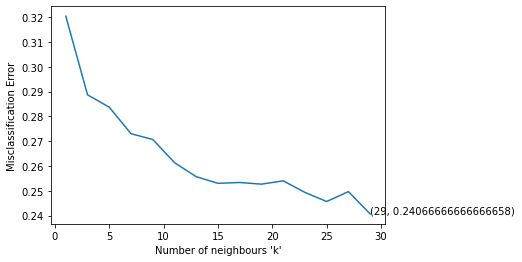

In [40]:
cv_scores = []
for k in klist:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())
    
error = [1 - x for x in cv_scores]
optimal_k = klist[error.index(min(error))]
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show()

In [41]:
# Accuracy on test data
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=-1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
acc = accuracy_score(y_test, y_pred) * 100
print('\nThe accuracy of the KNN classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the KNN classifier for k = 29 is 74.550000%


### TF- IDF Model

In [43]:
# Splitting into Test, Train and Cross-Validation set 
x_train = sorted_sample[0:3000]
y_train = y[0:3000]
x_test = sorted_sample[3000:5000]
y_test = y[3000:5000]

print ("Training Set - ", x_train.shape)
print ("Test Set - ", x_test.shape)

Training Set -  (3000, 11)
Test Set -  (2000, 11)


In [44]:
count_vect = TfidfVectorizer()
x_train = count_vect.fit_transform(x_train['CleanedText'].values)
x_train = x_train.todense()
x_train.shape

(3000, 8535)

In [45]:
x_test = count_vect.transform(x_test['CleanedText'].values)
x_test = x_test.todense()
x_test.shape

(2000, 8535)

In [46]:
klist = list(range(1,30,2))
klist

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29]

In [48]:
#code in the cell below takes approx 20 mins

In [47]:
cv_scores = []
for k in klist:
    knn = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
    scores = cross_val_score(knn, x_train, y_train, cv=10, scoring='accuracy', n_jobs=-1)
    cv_scores.append(scores.mean())

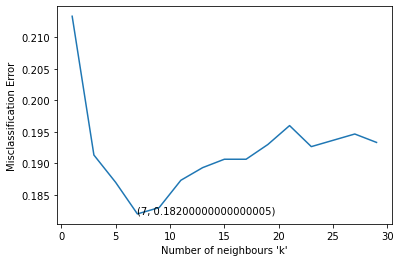

In [50]:
error = [1 - x for x in cv_scores]
optimal_k = klist[error.index(min(error))]
plt.plot(klist, error)
xy = (optimal_k, min(error))
plt.annotate('(%s, %s)' % xy, xy = xy, textcoords='data')
plt.xlabel("Number of neighbours 'k'")
plt.ylabel("Misclassification Error")
plt.show() 

In [52]:
# Accuracy on test data;
knn = KNeighborsClassifier(n_neighbors=optimal_k, n_jobs=-1)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
acc = accuracy_score(y_test, y_pred) * 100
print('\nThe accuracy of the KNN classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the KNN classifier for k = 7 is 80.600000%


### Conclusion:

1. With Cross Validation for Bag of Words Model we obtained an accuracy of 74.55% for the KNN classifier with k=29.

2. The TF-IDF Model provides an accuracy of 80.6% for the KNN classifier with k=7.

### References: 

- https://towardsdatascience.com/natural-language-processing-feature-engineering-using-tf-idf-e8b9d00e7e76
- https://www.kaggle.com/snap/amazon-fine-food-reviews
- https://www.youtube.com/watch?v=qQ14ymulmZA&t=641s
- https://www.youtube.com/watch?v=MK6T6bjNO90